In [1]:
#Import resources

#!pip install nltk scikit-learn pandas matplotlib
#%pip install seaborn

import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns


In [2]:
#Import libraries

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package ave

True

In [3]:
#Load the file
df = pd.read_csv("training_data_lowercase.csv")


In [4]:
#Data analyse
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34151 entries, 0 to 34150
Data columns (total 1 columns):
 #   Column                                                                            Non-Null Count  Dtype 
---  ------                                                                            --------------  ----- 
 0   0	donald trump sends out embarrassing new year‚s eve message; this is disturbing  34151 non-null  object
dtypes: object(1)
memory usage: 266.9+ KB


In [5]:
#Data analyse
df.head()

,0\tdonald trump sends out embarrassing new year‚s eve message; this is disturbing
0,0\tdrunk bragging trump staffer started russia...
1,0\tsheriff david clarke becomes an internet jo...
2,0\ttrump is so obsessed he even has obama‚s na...
3,0\tpope francis just called out donald trump d...
4,0\tracist alabama cops brutalize black boy whi...


In [6]:
#Remove "\t" and label first number and the headline 
df = pd.read_csv('training_data_lowercase.csv', sep='\t', header=None, names=['label', 'title'])
df.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [7]:
# Basic info
print("=== DATA TYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

=== DATA TYPES ===
label     int64
title    object
dtype: object

=== MISSING VALUES ===
label    0
title    0
dtype: int64


In [8]:
# Class distribution
print("=== CLASS DISTRIBUTION ===")
print(df['label'].value_counts())
print(f"\nPercentage:")
print(df['label'].value_counts(normalize=True) * 100)

=== CLASS DISTRIBUTION ===
label
0    17572
1    16580
Name: count, dtype: int64

Percentage:
label
0    51.452331
1    48.547669
Name: proportion, dtype: float64


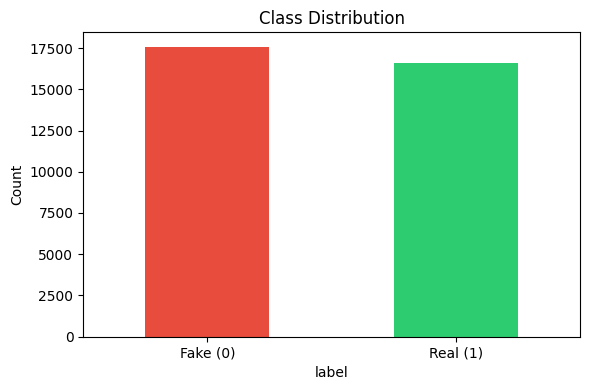

In [9]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'], ax=ax)
ax.set_xticklabels(['Fake (0)', 'Real (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.tight_layout()
plt.show()

In [10]:
# Add text length features for analysis
df['char_count'] = df['title'].str.len()
df['word_count'] = df['title'].str.split().str.len()

print("=== TITLE LENGTH BY CLASS (WORDS) ===")
print(df.groupby('label')['word_count'].describe())


=== TITLE LENGTH BY CLASS (WORDS) ===
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      17572.0  13.364671  4.495321  1.0  11.0  13.0  16.0  42.0
1      16580.0   9.916647  1.693058  4.0   9.0  10.0  11.0  20.0


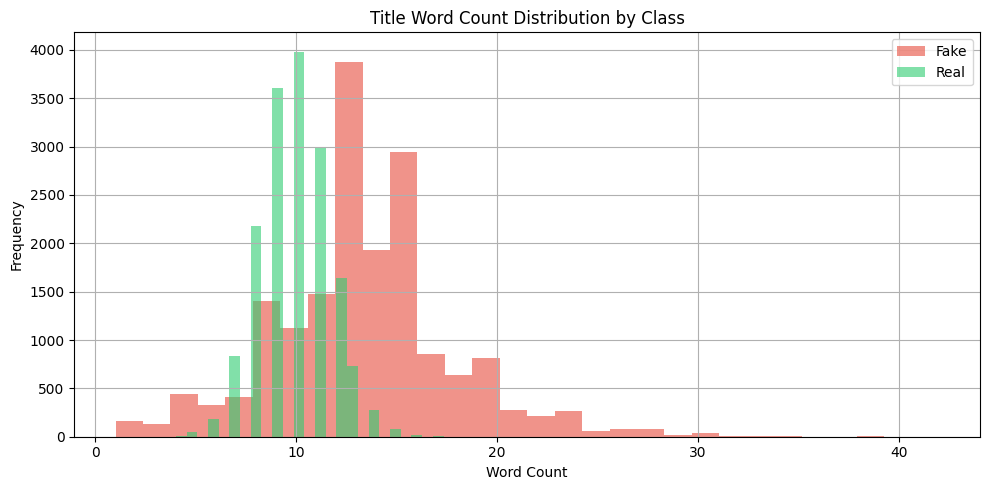

In [11]:
# Visualize word count distribution by class
fig, ax = plt.subplots(figsize=(10, 5))
df[df['label']==0]['word_count'].hist(alpha=0.6, label='Fake', bins=30, color='#e74c3c', ax=ax)
df[df['label']==1]['word_count'].hist(alpha=0.6, label='Real', bins=30, color='#2ecc71', ax=ax)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Title Word Count Distribution by Class')
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
# Check for tabs in titles
df['has_tab'] = df['title'].str.contains('\t')
print("=== TITLES WITH TABS ===")
print(f"Total: {df['has_tab'].sum()}")
print(f"\nBy class:")
print(df.groupby('label')['has_tab'].sum())

=== TITLES WITH TABS ===
Total: 3536

By class:
label
0       0
1    3536
Name: has_tab, dtype: int64


In [13]:
# Check for URLs in titles
df['has_url'] = df['title'].str.contains('http')
print("=== TITLES WITH URLs ===")
print(f"Total: {df['has_url'].sum()}")
print(f"\nBy class:")
print(df.groupby('label')['has_url'].sum())

=== TITLES WITH URLs ===
Total: 7

By class:
label
0    7
1    0
Name: has_url, dtype: int64


In [14]:
# Check for very short titles
short_titles = df[df['word_count'] <= 3]
print(f"=== VERY SHORT TITLES (≤3 words) ===")
print(f"Total: {len(short_titles)}")
print(f"\nBy class:")
print(short_titles['label'].value_counts())

=== VERY SHORT TITLES (≤3 words) ===
Total: 292

By class:
label
0    292
Name: count, dtype: int64


In [15]:
# Check for very long titles
long_titles = df[df['word_count'] >= 17]
print(f"=== VERY LONG TITLES (>=17 words) ===")
print(f"Total: {len(long_titles)}")
print(f"\nBy class:")
print(long_titles['label'].value_counts())

=== VERY LONG TITLES (>=17 words) ===
Total: 3366

By class:
label
0    3362
1       4
Name: count, dtype: int64


In [16]:
# Sample titles by class
print("=== SAMPLE FAKE NEWS TITLES ===")
for title in df[df['label']==0]['title'].head(5):
    print(f"- {title}")

print("\n=== SAMPLE REAL NEWS TITLES ===")
for title in df[df['label']==1]['title'].head(5):
    print(f"- {title}")

=== SAMPLE FAKE NEWS TITLES ===
- donald trump sends out embarrassing new year‚s eve message; this is disturbing
- drunk bragging trump staffer started russian collusion investigation
- sheriff david clarke becomes an internet joke for threatening to poke people ‚in the eye‚
- trump is so obsessed he even has obama‚s name coded into his website (images)
- pope francis just called out donald trump during his christmas speech

=== SAMPLE REAL NEWS TITLES ===
- as u.s. budget fight looms	republicans flip their fiscal script
- u.s. military to accept transgender recruits on monday: pentagon
- senior u.s. republican senator: 'let mr. mueller do his job'
- fbi russia probe helped by australian diplomat tip-off: nyt
- trump wants postal service to charge 'much more' for amazon shipments


### EDA Summary

**Key Findings:**
- Dataset: 34,152 rows, well-balanced classes (~51% fake, ~49% real)
- Fake news titles are longer (avg 13 words) vs real (avg 10 words)
- Tab characters appear ONLY in real news (3,536 titles) - strong signal
- URLs appear ONLY in fake news titles
- Very short titles (≤2 words) are all fake news

**Potential Features:**
1. `word_count` - title length
2. `has_tab` - presence of tab character
3. `has_url` - presence of URL
4. Text vectorization (TF-IDF)

In [17]:

stop_words = set(stopwords.words('english'))
print(stop_words)

{'but', 'up', "it's", "aren't", "he'll", "i'd", 'can', 'which', "shan't", 'now', 'needn', "we'd", 'during', 'm', 'above', "hasn't", 'ours', 'd', "that'll", 'when', 'why', 'between', 'for', 'y', "she'd", 'they', 'have', "he'd", 'few', 'was', 'so', 'again', "we'll", 'a', 'her', 'same', 'an', 'is', 'once', 'on', 'we', 'here', "we've", "she's", 'no', "shouldn't", 'about', 'himself', 'after', 'by', "mustn't", "doesn't", 'below', "they'll", 'both', 'if', "isn't", 'and', 'before', 'such', 'any', 'out', 'hasn', 'most', 'themselves', 'just', 'further', 'am', 'did', 'to', 'aren', "he's", 'wasn', 'mustn', 'then', 'those', 'hadn', 'won', 'theirs', 'own', "wouldn't", 'yourself', 'his', 'are', 'under', 'me', 'do', 'she', 'don', 'he', "it'd", "wasn't", 'other', 'its', "weren't", 'at', 'couldn', 'them', 'doesn', 'too', 'whom', 'their', "haven't", 'some', 'had', "hadn't", 'very', 'not', 'didn', 'who', 'be', 'this', 'were', 'i', "i'm", 'it', 'mightn', 's', 'haven', 'over', 'the', 'because', 'with', 'all

In [18]:

# Replace tabs with spaces
df = df.replace('\t', ' ')
    
# Fix common encoding issues with apostrophes
df = df.replace('‚', "'")
df = df.replace(''', "'")
df = df.replace(''', "'")
    
# Remove extra whitespace
#df = ' '.join(df.split())
stop_words = set(stopwords.words('english'))
pattern = re.compile('[%s]' % re.escape(string.punctuation))

preprocessed_df = []

for doc in df:          # doc is a STRING here
    # Step 1: lowercase + tokenize
    tokens = word_tokenize(doc.lower())

# Step 2: remove stopwords & non-alphabetic tokens
    filtered_tokens = [
        word for word in tokens
        if word.isalpha() and word not in stop_words

    ]
 # Step 3: remove punctuation (extra safety)
    clean_tokens = [
        pattern.sub('', word) for word in filtered_tokens
        if pattern.sub('', word) != ''
    ]
    
    preprocessed_df.append(clean_tokens)


In [19]:
# Step 1: Initialize the TfidfVectorizer

tfidf = TfidfVectorizer()

# Step 2: Fit and transform the corpus into a TF-IDF representation

clean_tokens = [" ".join(sentence) for sentence in preprocessed_df]
titles_tfidf = tfidf.fit_transform(clean_tokens)

In [20]:
type(titles_tfidf)
print(titles_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (6, 2)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0


SBERT + Logistic Regression

In [22]:
import sys
sys.executable

'C:\\Users\\Usuario\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\python.exe'

In [26]:
!"C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe" -m pip install -U sentence-transformers

  Using cached sentence_transformers-5.2.2-py3-none-any.whl.metadata (16 kB)
  Using cached transformers-5.0.0-py3-none-any.whl.metadata (37 kB)
  Using cached huggingface_hub-1.4.0-py3-none-any.whl.metadata (13 kB)
  Using cached torch-2.10.0-cp311-cp311-win_amd64.whl.metadata (31 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-win_amd64.whl.metadata (7.4 kB)
Using cached sentence_transformers-5.2.2-py3-none-any.whl (494 kB)
Using cached huggingface_hub-1.4.0-py3-none-any.whl (553 kB)
Using cached torch-2.10.0-cp311-cp311-win_amd64.whl (113.7 MB)
Using cached transformers-5.0.0-py3-none-any.whl (10.1 MB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached tokenizers-0.22.2-cp39-abi3-win_amd64.whl (2.7 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Usuario\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\torch\\include\\ATen\\native\\transformers\\cuda\\mem_eff_attention\\iterators\\predicated_tile_access_iterator_residual_last.h'


[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [29]:
#%pip install -U sentence-transformers
#from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

Create TF-IDF

In [31]:
#Initialize TF-IDF vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_tfidf = vectorizer.fit_transform(df["title"])
y = df["label"]

In [32]:
#Reduce to dense embeddings
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
X_emb = svd.fit_transform(X_tfidf)

In [33]:
#Train Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X_emb, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

model.fit(X_train, y_train)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [34]:
#Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9068950373298199
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3515
           1       0.89      0.92      0.91      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

